In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

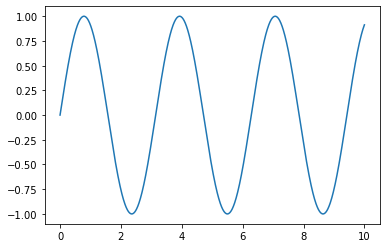

In [3]:
#Face 1:jax和numpy的用法几乎一样
#使用numpy绘制图形
x_np = np.linspace(0, 10, 1000)
y_np = 2*np.sin(x_np)*np.cos(x_np)
plt.plot(x_np, y_np)

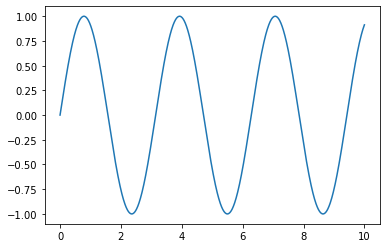

In [5]:
#使用jax绘图，会得到一模一样的效果，jax的使用方法和numpy几乎一样
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2*jnp.sin(x_jnp)*jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)


In [6]:
#Face 2: JAX arrays are immutable(不可改变)
size = 10
index = 0 
value = 23

#NumPy: mutable array
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
#jax:immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value #object does not support item assignment.
print(x)

In [8]:
#Solution
y = x.at[index].set(value)
#只能生成一个新的数组，然后更改其指定下标的value
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [10]:
#Fact 3:JAX handles random numbers differently
#(for a good reason!)
seed = 0
key = random.PRNGKey(seed)

#在生成随机数的时候，必须显式传递这个参数
x = random.normal(key, (10,))
print(type(x), x)


<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [14]:
# Transfrom function: jit() 加速函数的执行
#Simple helper visualization function
def visualize_fn(fn, l = -10, r = 10, n = 1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

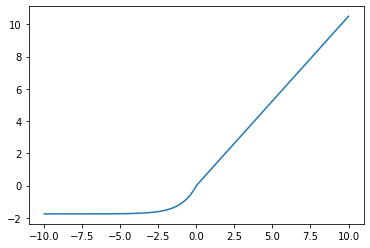

non-jit version
3.51 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
jit version:
453 µs ± 133 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
#Define a function
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

#let's compile it
selu_jit = jit(selu)

#Visualiz SELU 
visualize_fn(selu)

#BGenchmark non-jit vs jit version
data =random.normal(key, (1000000,))

print("non-jit version")
%timeit selu(data).block_until_ready()

print("jit version:")
%timeit selu_jit(data).block_until_ready()

In [20]:
# Transfrom function 2: grad()
# Fisrt example(automatic diff)
def sum_logistic(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
print(x)
loss = sum_logistic #让sum_logistic作为loss函数

grad_loss = grad(loss)
print(grad_loss(x))

[0. 1. 2.]
[0. 2. 4.]


`grad()`函数
```python 
grad(函数，argnums=(变量下标))
```
>这里表示对**函数**进行求导，
>第二个参数是决定对哪个变量进行求偏导，括号里面是变量所对应的下标
>如果一个函数f(x, y)
>那么如果对x求导，就是 grad(f, argnums=(0)),因为x是f函数参数列表中，下标为0的元素，
>同理，如果是对y求偏导，就是argnums=(1)
>如果对x,y同时求偏导，就是argnums=(0,1)


In [33]:
# Second example (automatic diff# Second example (automatic diff)# Second example (automatic diff))

x = 1. #example input
y = 1.
#lambda关键字，可以快速定义一个函数
#lambda 变量1， 变量2：关于变量1，变量2的函数式子
f =  lambda x, y:x**2 + x + 4 + y**2 #simple 2nd order polynomial fn
#visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f, argnums=(0)) # 2*x + 1
dfdy = grad(f, argnums=(1)) # 2*y 
dfdxdy = grad(f, argnums=(0,1))
#d2fdx = grad(dfdx) # 2 
#d3fdx =  grad(d2fdx) # 0

print(f(x, y), dfdx(x, y), dfdy(x, y), dfdxdy(x, y))

7.0 3.0 2.0 (DeviceArray(3., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))


In [35]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2 #

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dxdx = 2
# d2f/dydy = 2
# d2f/dxdy = 0
# d2f/dydx = 0

# H = [
#   [d2f/dxdx, d2f/dxdy],
#   [d2f/dydx, d2f/dydy]
# ]

def hession(f):
    return jit(jacfwd(jacrev(f, argnums=(0,1)),argnums=(0,1)))

print(f'Jacobian={jacrev(f, argnums=(0,1))(1.,1.)}')
print(f'Full Hession={hession(f)(1.,1.)}')

Jacobian=(DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hession=((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


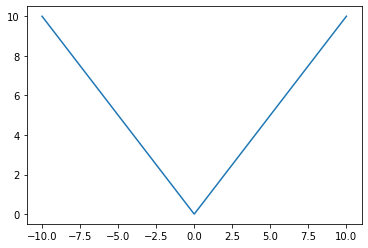

1 1
1.0 -1.0


In [39]:
# Edge case |x|, how does JAX handle it?
f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.), dfdx(-1.))

In [52]:
#vmap()
#Write your functions as if you were dealing with a single datapoint
W = random.normal(key, (150, 100)) #eg, weights of a linear NN layer
batched_x = random.normal(key, (10, 100)) #e.g a batch of 10 flattened images

def apply_matrix(W,x):
    return jnp.dot(W, x)


In [43]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()


Naively batched
837 µs ± 25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
#@jit将函数标记为由JIT编译器进行优化。提高代码运行速度
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T) #(10, 100) *(100, 150) ->(10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()


Manually batched
6.92 µs ± 177 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [55]:
from jax import vmap

@jit #note: we can arbitrarily compose JAX transforms
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

Auto-vectorized with vmap
33 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# Example 1: lax is stricter
from jax import lax

print(jnp.add(1, 1.0))
print(lax.add(1, 1.0))